In [ ]:
%%capture
!pip install lightning-bolts

### VAE Class

In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [ ]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=30)
trainer.fit(vae, datamodule)

INFO:lightning_fabric.utilities.seed:Global seed set to 1234
<ipython-input-2-ad0a18dec901>:17: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/usr/local/lib/python3.10/dist-pac

100%|██████████| 170498071/170498071 [00:13<00:00, 12507343.61it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Output with correct labels

100%|██████████| 170498071/170498071 [00:19<00:00, 8569480.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


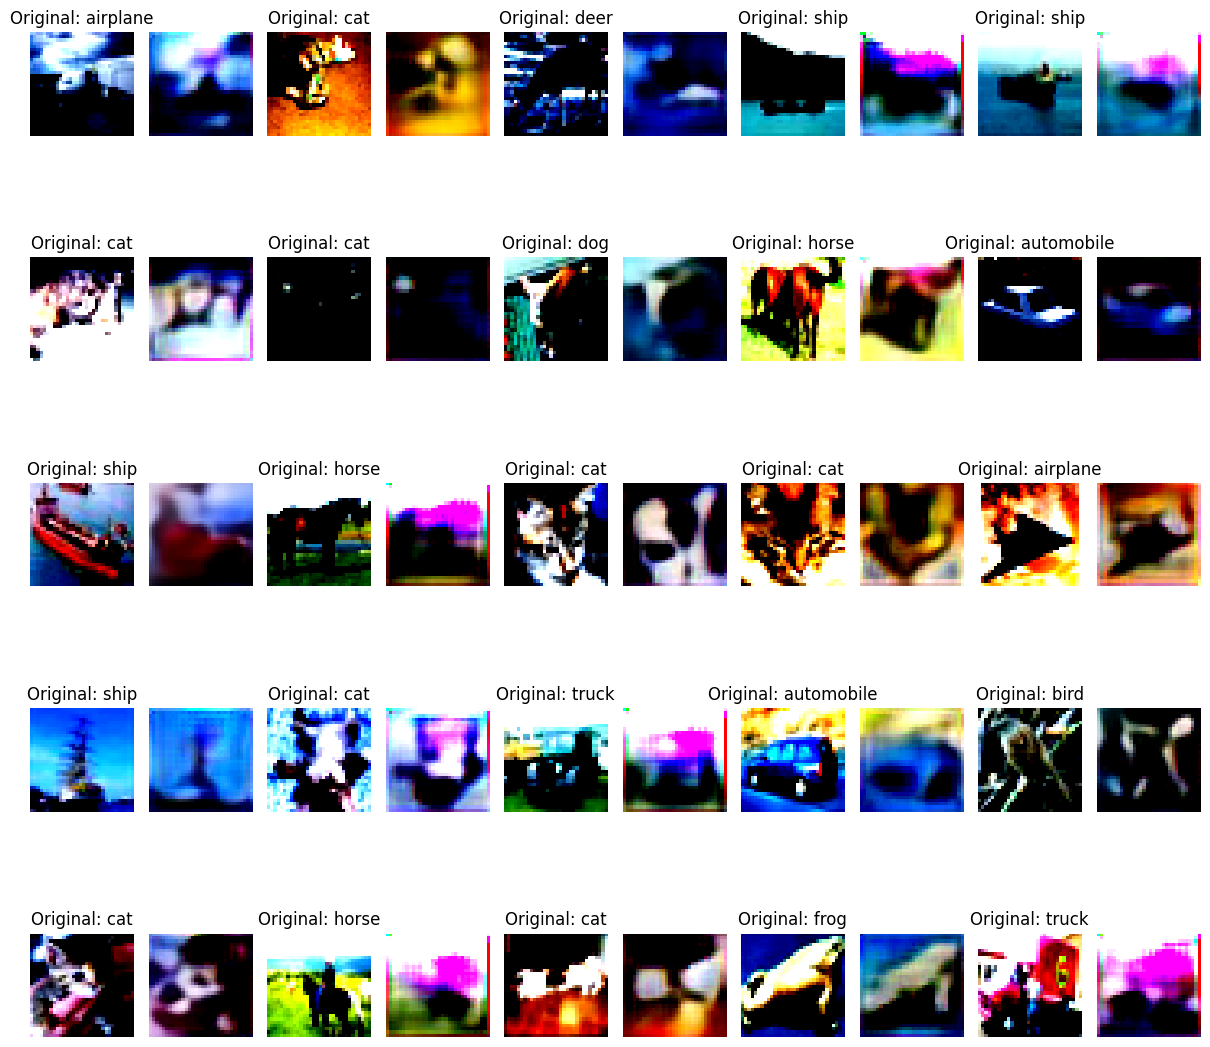

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

# Create a custom dataset with only correct labels
class CorrectLabelDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, correct_label = self.original_dataset[idx]
        return image, correct_label

cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Define a transformation for the images (assuming CIFAR-10 normalization)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(), normalize])

# Create the original CIFAR-10 dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the custom dataset with correct labels only
custom_dataset = CorrectLabelDataset(cifar10_dataset)
data_loader = DataLoader(custom_dataset, batch_size=1, shuffle=True)

# Initialize lists to accumulate images and labels
images_to_plot = []
labels_to_plot = []

# Loop through the dataset and make predictions
vae.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for image, correct_label in data_loader:
        correct_label = correct_label.item()

        # Encode the image and generate a prediction
        image = image.to(vae.device)
        x_encoded = vae.encoder(image)
        mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
        std = torch.exp(log_var / 2)

        # Generate a prediction
        z = mu + std * torch.randn_like(std)  # Sample from the learned distribution
        predicted_image = vae.decoder(z)

        # Accumulate images and labels
        images_to_plot.append((image, predicted_image))
        labels_to_plot.append(f"Original: {cifar10_labels[correct_label]}")

        # Display up to 25 images in a 5x5 grid
        if len(images_to_plot) >= 25:
            break

# Create a figure for the images
num_images = len(images_to_plot)
num_rows = 5
num_cols = 5

plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    # Clip pixel values to the valid range [0, 1]
    original_image = np.clip(images_to_plot[i][0].squeeze().permute(1, 2, 0).numpy(), 0, 1)
    plt.imshow(original_image)
    plt.title(labels_to_plot[i])
    plt.axis('off')

    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    # Clip pixel values to the valid range [0, 1]
    predicted_image = np.clip(images_to_plot[i][1].squeeze().permute(1, 2, 0).numpy(), 0, 1)
    plt.imshow(predicted_image)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Output with incorrect labels

Files already downloaded and verified


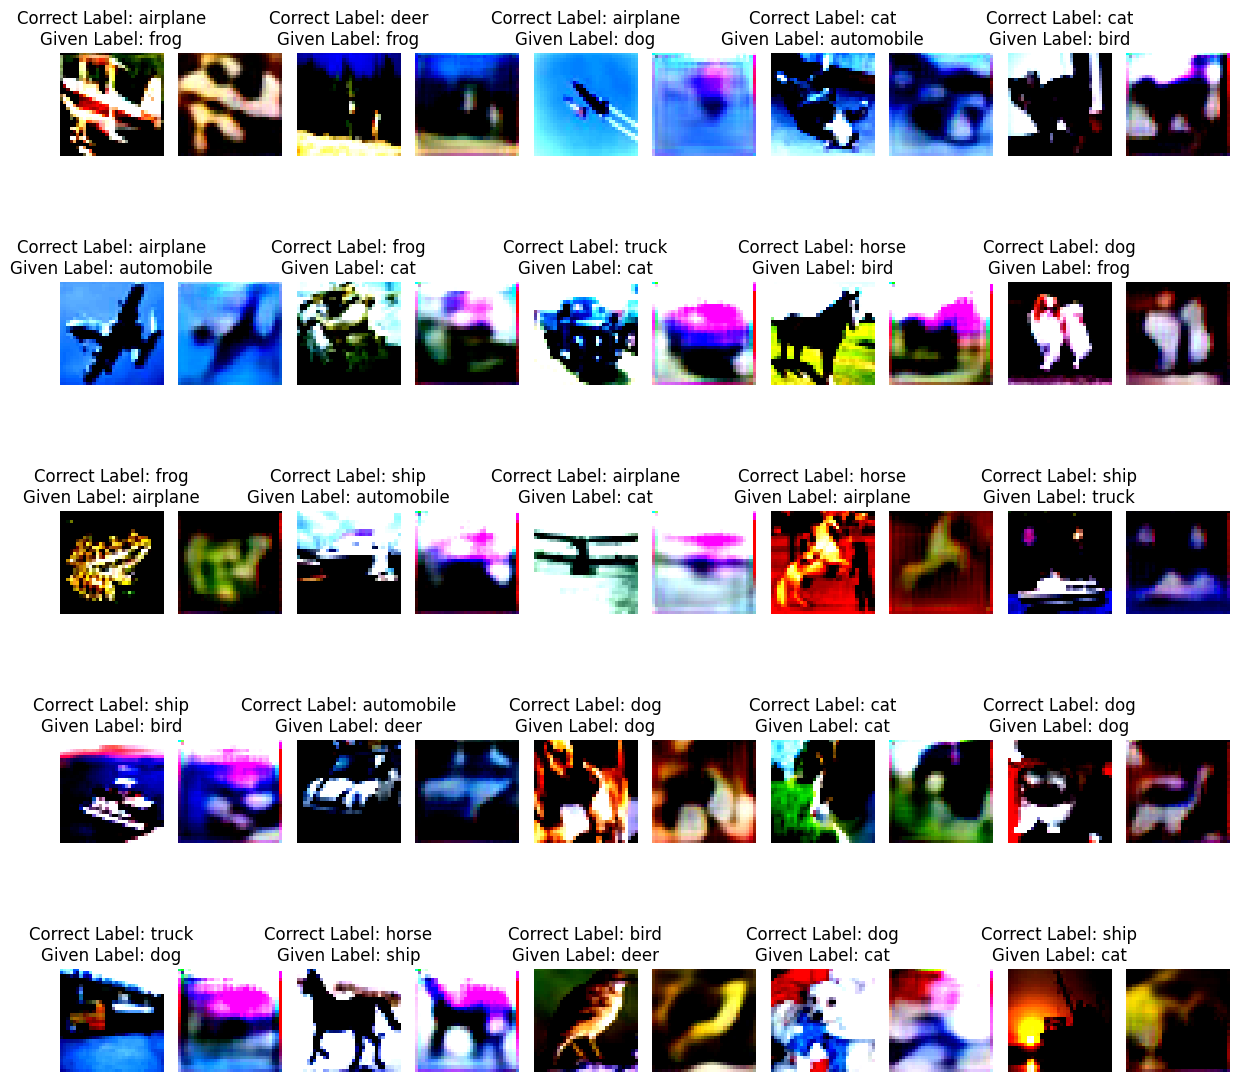

In [ ]:
import random
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Create a custom dataset with incorrect labels
class IncorrectLabelDataset(Dataset):
    def __init__(self, original_dataset, incorrect_labels):
        self.original_dataset = original_dataset
        self.incorrect_labels = incorrect_labels

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, correct_label = self.original_dataset[idx]
        incorrect_label = self.incorrect_labels[idx]
        return image, correct_label, incorrect_label

# Load your pre-trained VAE model (assuming 'vae' is your trained model)

# Define a transformation for the images (assuming CIFAR-10 normalization)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(), normalize])

# Create the original CIFAR-10 dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the custom dataset with random incorrect labels
incorrect_labels = [random.randint(0, 9) for _ in range(len(cifar10_dataset))]  # Generate random incorrect labels
custom_dataset = IncorrectLabelDataset(cifar10_dataset, incorrect_labels)
data_loader = DataLoader(custom_dataset, batch_size=1, shuffle=True)

# Initialize lists to accumulate images and labels
images_to_plot = []

# Function to make predictions based on incorrect labels
def predict_with_incorrect_label(image, incorrect_label):
    image = image.to(vae.device)

    # Encode the image
    x_encoded = vae.encoder(image)
    mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
    std = torch.exp(log_var / 2)

    # Create a distribution based on the incorrect label
    incorrect_label_tensor = torch.tensor([incorrect_label]).float().to(vae.device)
    z = mu + std * incorrect_label_tensor  # Use incorrect_label as a factor
    x_hat = vae.decoder(z)

    return x_hat

# Assuming CIFAR-10 labels for simplicity (replace with your own labels)
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Loop through the dataset and make predictions based on incorrect labels
vae.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for image, correct_label, incorrect_label in data_loader:
        correct_label = correct_label.item()
        incorrect_label = incorrect_label.item()

        # Generate a prediction
        predicted_image = predict_with_incorrect_label(image, incorrect_label)

        # Accumulate images
        images_to_plot.append((image, predicted_image, correct_label, incorrect_label))

        # Display up to 25 pairs of actual and predicted images
        if len(images_to_plot) >= 25:
            break

# Create a figure for the images
num_images = len(images_to_plot)
num_rows = 5
num_cols = 5

plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    # Clip pixel values to the valid range [0, 1] for the actual image
    actual_image = np.clip(images_to_plot[i][0].squeeze().permute(1, 2, 0).numpy(), 0, 1)
    correct_label_text = f"Correct Label: {cifar10_labels[images_to_plot[i][2]]}"
    incorrect_label_text = f"Given Label: {cifar10_labels[images_to_plot[i][3]]}"
    plt.imshow(actual_image)
    plt.title(f"{correct_label_text}\n{incorrect_label_text}")
    plt.axis('off')

    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    # Clip pixel values to the valid range [0, 1] for the predicted image
    predicted_image = np.clip(images_to_plot[i][1].squeeze().permute(1, 2, 0).numpy(), 0, 1)
    plt.imshow(predicted_image)
    plt.axis('off')

plt.tight_layout()
plt.show()
